# Multi-Class Classification with Perceptron

Lab Assignment from [AI for Beginners Curriculum](https://github.com/microsoft/ai-for-beginners).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import pylab
import random

You can use the following perceptron training code from the lecture:

In [2]:
def train(positive_examples, negative_examples, num_iterations = 100, eta = 1, report_frequency = 10):
    num_dims = positive_examples.shape[1]
    weights = np.zeros((num_dims,1)) # initialize weights
    
    pos_count = positive_examples.shape[0]
    neg_count = negative_examples.shape[0]
    
    for i in range(num_iterations):
        pos = random.choice(positive_examples)
        neg = random.choice(negative_examples)

        z = np.dot(pos, weights)   
        if z < 0:
            weights = weights + eta * pos.reshape(weights.shape)

        z  = np.dot(neg, weights)
        if z >= 0:
            weights = weights - eta * neg.reshape(weights.shape)
            
        if i % report_frequency == 0:             
            pos_out = np.dot(positive_examples, weights)
            neg_out = np.dot(negative_examples, weights)        
            pos_correct = (pos_out >= 0).sum() / float(pos_count)
            neg_correct = (neg_out < 0).sum() / float(neg_count)
            print("Iteration={}, pos correct={}, neg correct={}".format(i,pos_correct,neg_correct))

    return weights

In [3]:
def accuracy(weights, test_x, test_labels):
    res = np.dot(np.c_[test_x,np.ones(len(test_x))],weights)
    return (res.reshape(test_labels.shape)*test_labels>=0).sum()/float(len(test_labels))

### Reading the Dataset

This code download the dataset from the repository on the internet. You can also manually copy the dataset from `/data` directory of AI Curriculum repo.

In [4]:
if not os.path.exists('mnist.pkl'):
    !wget https://raw.githubusercontent.com/mnielsen/neural-networks-and-deep-learning/master/data/mnist.pkl.gz
    !gzip -d mnist.pkl.gz

with open('mnist.pkl', 'rb') as mnist_pickle:
    MNIST = pickle.load(mnist_pickle, encoding='latin1')

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01171875 0.0703125
 0.0703125  0.0703125  0.4921875  0.53125    0.68359375 0.1015625
 0.6484375  0.99609375 0.96484375 0.49609375 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.1171875  0.140625
 0.3671875  0.6015625 ]
5


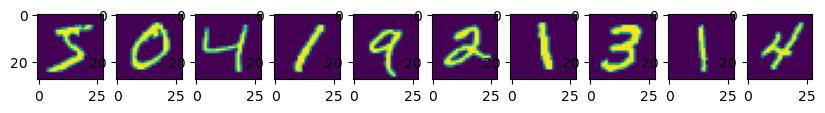

In [5]:
TRAIN, TEST = 0, 1
FEATURES, LABELS = 0, 1

print(MNIST[TRAIN][FEATURES][0][130:180])
print(MNIST[TRAIN][LABELS][0])
features = MNIST[TRAIN][FEATURES].astype(np.float32) / 256.0
labels = MNIST[TRAIN][LABELS]
fig = pylab.figure(figsize=(10,5))
for i in range(10):
    ax = fig.add_subplot(1,10,i+1)
    pylab.imshow(features[i].reshape(28,28))
pylab.show()

Code to create *one-vs-other* dataset for two-digit classification. You need to modify this code to create *one-vs-all* dateset.

In [6]:
def set_mnist_pos_neg(positive_label, negative_label):
    positive_indices = [i for i, j in enumerate(MNIST[TRAIN][LABELS]) 
                          if j == positive_label]
    negative_indices = [i for i, j in enumerate(MNIST[TRAIN][LABELS]) 
                          if j == negative_label]

    positive_images = MNIST[TRAIN][FEATURES][positive_indices]
    negative_images = MNIST[TRAIN][FEATURES][negative_indices]

    return positive_images, negative_images

Now you need to:
1. Create 10 *one-vs-all* datasets for all digits
1. Train 10 perceptrons
1. Define `classify` function to perform digit classification
1. Measure the accuracy of classification and print *confusion matrix*
1. [Optional] Create improved `classify` function that performs the classification using one matrix multiplication.

## Implementation Starts Here

### Create 10 One-vs-all Datasets

In [7]:
def set_mnist_one_vs_all(positive_label):
    positive_indices = [i for i, j in enumerate(MNIST[TRAIN][LABELS]) 
                          if j == positive_label]
    negative_indices = [i for i, j in enumerate(MNIST[TRAIN][LABELS]) 
                          if j != positive_label]
    
    positive_images = MNIST[TRAIN][FEATURES][positive_indices]
    negative_images = MNIST[TRAIN][FEATURES][negative_indices]

    return positive_images, negative_images

positive_data_set, negative_data_set = [], []
for i in range(10):
    positive_images, negative_images = set_mnist_one_vs_all(i)
    positive_data_set.append(positive_images)
    negative_data_set.append(negative_images)

### Train 10 Perceptrons

In [8]:
weights = []
for positive_label in range(0, 10):
    positive_images, negative_images = set_mnist_one_vs_all(positive_label)
    weights.append(train(positive_images, negative_images, num_iterations=1000, eta=0.001, report_frequency=100))

Iteration=0, pos correct=0.0, neg correct=1.0
Iteration=100, pos correct=0.98661800486618, neg correct=0.8464320582231295
Iteration=200, pos correct=0.9975669099756691, neg correct=0.7795997159847342
Iteration=300, pos correct=0.9667477696674777, neg correct=0.9663175645690956
Iteration=400, pos correct=0.9785077047850771, neg correct=0.930105618176977
Iteration=500, pos correct=0.9699918896999189, neg correct=0.953692198455667
Iteration=600, pos correct=0.9734387672343877, neg correct=0.9616357504215851
Iteration=700, pos correct=0.9677615571776156, neg correct=0.9685586225259608
Iteration=800, pos correct=0.9890510948905109, neg correct=0.9036788852400817
Iteration=900, pos correct=0.9635036496350365, neg correct=0.9730629271323333
Iteration=0, pos correct=0.0, neg correct=1.0
Iteration=100, pos correct=0.9839732300105671, neg correct=0.9387437390009477
Iteration=200, pos correct=0.9461077844311377, neg correct=0.9877713099589369
Iteration=300, pos correct=0.9568510038746038, neg cor

### Define `classify` Function

In [9]:
def classify(image):
    best_digit, best_output = 0, np.dot(image, weights[0])
    for digit in range(1, 10):
        output = np.dot(image, weights[digit])
        if output > best_output:
            best_digit, best_output = digit, output
    return best_digit

### Measure Accuracy and Print Confusion Matrix

In [10]:
def print_confusion(classify = classify):
    confusion = np.zeros([10, 10])
    test_count = [0] * 10

    num_tests = len(MNIST[TEST][FEATURES])
    for i in range(num_tests):
        expected = MNIST[TEST][LABELS][i]
        actual = classify(MNIST[TEST][FEATURES][i])
        test_count[expected] += 1
        confusion[expected, actual] += 1

    for i in range(10):
        confusion[i] /= test_count[i]
    np.set_printoptions(precision=3, suppress=True)
    print(confusion)

print_confusion()

[[0.933 0.    0.006 0.001 0.    0.023 0.003 0.    0.031 0.002]
 [0.    0.869 0.002 0.002 0.    0.008 0.001 0.002 0.115 0.001]
 [0.015 0.023 0.768 0.026 0.012 0.022 0.008 0.013 0.104 0.008]
 [0.013 0.009 0.012 0.538 0.    0.27  0.004 0.005 0.141 0.01 ]
 [0.001 0.006 0.005 0.001 0.815 0.012 0.002 0.002 0.078 0.077]
 [0.03  0.    0.011 0.009 0.011 0.847 0.011 0.003 0.052 0.026]
 [0.016 0.002 0.028 0.002 0.031 0.056 0.785 0.001 0.063 0.017]
 [0.019 0.008 0.014 0.    0.006 0.008 0.    0.833 0.045 0.067]
 [0.006 0.01  0.007 0.002 0.002 0.046 0.    0.002 0.904 0.022]
 [0.01  0.004 0.003 0.001 0.055 0.034 0.    0.045 0.07  0.777]]


In [11]:
from sklearn.decomposition import PCA
import pylab

def pca_analysis(positive_label):
    positive_images, negative_images = set_mnist_one_vs_all(positive_label)
    M = np.append(positive_images, negative_images, 0)

    mypca = PCA(n_components=2)
    mypca.fit(M)
    
    pos_points = mypca.transform(positive_images[:200])
    neg_points = mypca.transform(negative_images[:200])

    pylab.plot(pos_points[:,0], pos_points[:,1], 'bo')
    pylab.plot(neg_points[:,0], neg_points[:,1], 'ro')

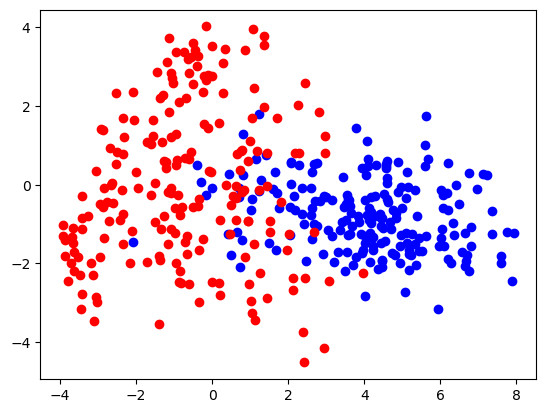

In [12]:
pca_analysis(0)

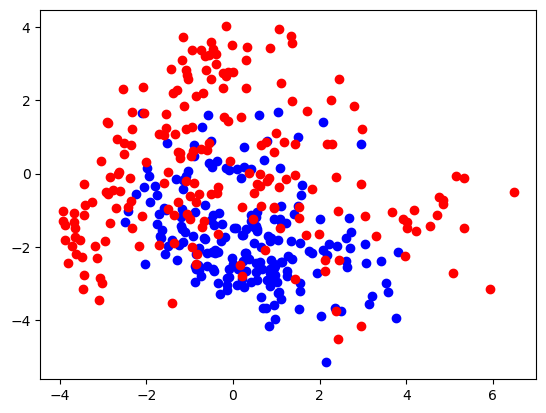

In [15]:
pca_analysis(3)

### Create `classify` Function with One Matrix Multiplication

In [14]:
weight_matrix = np.concatenate(weights, axis=1)

def classify2(image):
    return image.T.dot(weight_matrix).argmax()

print_confusion(classify=classify2)

[[0.933 0.    0.006 0.001 0.    0.023 0.003 0.    0.031 0.002]
 [0.    0.869 0.002 0.002 0.    0.008 0.001 0.002 0.115 0.001]
 [0.015 0.023 0.768 0.026 0.012 0.022 0.008 0.013 0.104 0.008]
 [0.013 0.009 0.012 0.538 0.    0.27  0.004 0.005 0.141 0.01 ]
 [0.001 0.006 0.005 0.001 0.815 0.012 0.002 0.002 0.078 0.077]
 [0.03  0.    0.011 0.009 0.011 0.847 0.011 0.003 0.052 0.026]
 [0.016 0.002 0.028 0.002 0.031 0.056 0.785 0.001 0.063 0.017]
 [0.019 0.008 0.014 0.    0.006 0.008 0.    0.833 0.045 0.067]
 [0.006 0.01  0.007 0.002 0.002 0.046 0.    0.002 0.904 0.022]
 [0.01  0.004 0.003 0.001 0.055 0.034 0.    0.045 0.07  0.777]]
